In [1]:
###################################################
import emcee
import numpy as np
import scipy
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
import time
import astropy.units as u
import pyccl as ccl
import numpy as np
import pandas
import pandas as pd
from crow import mass_proxy
import pyarrow.parquet as pq
import pyarrow as pa

from astropy.table import Table

# In this notebook, we will use the CosmoDC2 HALO catalog, and generate our own richness. Thus we can only perform cluster counts analysis

## Generate the richness catalog

In [2]:


# Read the FITS file into a table
catalog = Table.read("/sps/lsst/users/maguena/cats/dc2/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0.fits")

# ----------------------------
# Murata model
# ----------------------------
m_pivot = 14.3
z_pivot = 0.5

mass_richness = mass_proxy.MurataUnbinned(m_pivot, z_pivot)

mass_richness.parameters["mu0"] = 3.2
mass_richness.parameters["mu1"] = 0.8
mass_richness.parameters["mu2"] = 0.1

mass_richness.parameters["sigma0"] = 0.5
mass_richness.parameters["sigma1"] = 0.00
mass_richness.parameters["sigma2"] = 0.00

rng = np.random.default_rng()
display(catalog)
# ----------------------------
# Output parquet writer
# ----------------------------
output_file = "./cosmodc2_with_richness.parquet"
    
redshift = catalog["redshift_true"]
halo_mass = catalog["m200c"]
log10_mass = np.log10(halo_mass)

mu_ln = mass_richness.get_ln_mass_proxy_mean(log10_mass, redshift)
sigma_ln = mass_richness.get_ln_mass_proxy_sigma(log10_mass, redshift)
ln_richness = rng.normal(mu_ln, sigma_ln)

df = pd.DataFrame(
    {
        "redshift": np.array(redshift, dtype=float),
        "halo_mass": np.array(halo_mass, dtype=float),
        "log10_halo_mass": np.array(log10_mass, dtype=float),
        "richness": np.array(np.exp(ln_richness), dtype=float),
    }
)

table = pa.Table.from_pandas(df, preserve_index=False)

writer = pq.ParquetWriter(output_file, table.schema)

writer.write_table(table)

writer.close()
display(df)
print(f"Saved richness catalog to {output_file}")

halo_id,ra_true,dec_true,ra,dec,redshift_true,mass_fof,m200c,r200c,skysim_halo_id,NMEM,richness,NMEM_g_star2,NMEM_r_star2,NMEM_i_star2,NMEM_z_star2,NMEM_y_star2,richness_g_star2,richness_r_star2,richness_i_star2,richness_z_star2,richness_y_star2,ra_bary,dec_bary
int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64
1600020475,50.77596621112012,-27.11267297840223,50.775875822529436,-27.112584328955446,0.04530489444732666,2.247e+13,18901145086557.746,0.5539122181878964,4308786475,14,8.259415690053675,4,2,2,2,2,3.3159297517335684,2.0,2.0,2.0,2.0,50.86080257640612,-27.111068884566034
2700020475,49.46685631106464,-25.960657456295777,49.466814189348334,-25.960541211222015,0.04615640640258789,1.633e+13,15062094204754.93,0.5136732064502341,5608786475,14,7.310438276043445,7,5,5,5,5,3.9505018568471444,3.162710828265532,3.162710828265532,3.162710828265532,3.162710828265532,49.430749682006216,-26.004253136511434
17200020453,50.16400668612118,-25.25905307744378,50.16585579512233,-25.259404686564693,0.08653247356414795,2.283e+13,20441971397588.734,0.5883426733419929,9508786453,12,5.623277102797734,5,5,5,4,4,3.3387389360236903,3.3387389360236903,3.3387389360236903,3.130245439035445,3.130245439035445,50.10887874151731,-25.222612608640762
19000020453,49.51595503782168,-26.130631687629403,49.51865674267036,-26.131426039026245,0.09413313865661621,1.199e+13,10668658238016.902,0.47378993370163613,29908786453,15,6.997234500189672,7,7,7,7,7,3.975938934627579,3.975938934627579,3.975938934627579,3.975938934627579,3.975938934627579,49.526283728873516,-26.143323644925193
19800020453,50.68971804154461,-26.886508987581664,50.691634217578326,-26.88681304144144,0.08739697933197021,8.412e+13,71624983358738.03,0.8935768839339135,10408786453,25,10.377440167337566,12,11,9,8,8,5.102184303491505,4.807846043434688,4.353673518160678,4.0503547588246684,4.0503547588246684,50.71067924047927,-26.883765517046655
32800020453,51.49229315287324,-26.308837160731073,51.49405530538187,-26.309071814426567,0.08795535564422607,1.328e+13,10371945197971.832,0.4693405728944591,14908786453,7,4.078294904689155,2,2,2,2,2,1.284161206475952,1.284161206475952,1.284161206475952,1.284161206475952,1.284161206475952,51.53207787114288,-26.281769096943737
2000020442,51.02799219278836,-25.768148487504888,51.03054382968504,-25.767733992572435,0.10751283168792725,3.555e+13,31256384653340.848,0.6889763852240335,9408786442,22,9.068648511775608,3,3,3,3,2,1.7669316487994353,1.7669316487994353,1.7669316487994353,1.7669316487994353,1.5330209172234177,51.04052597864433,-25.76994686512187
32300020442,51.47772552281113,-25.82579874206229,51.48013416475692,-25.825311694587846,0.10751473903656006,1.339e+13,11587427913554.93,0.49502278717470843,43208786442,10,5.4538674639470575,5,4,4,3,3,3.6826146155436636,2.6826146155436636,2.6826146155436636,2.0956992167416817,2.0956992167416817,51.46172414586285,-25.805957090122217
33300020442,50.31241043560731,-26.69591460405023,50.315518939516316,-26.69559169836869,0.108817458152771,3.434e+13,29876928281239.438,0.6786574780101507,44708786442,16,6.788349932828027,8,8,8,8,8,4.952319670491652,4.952319670491652,4.952319670491652,4.952319670491652,4.952319670491652,50.28802465790821,-26.712593565283026


,redshift,halo_mass,log10_halo_mass,richness
0,0.045305,1.890115e+13,13.276488,3.855527
1,0.046156,1.506209e+13,13.177885,2.342586
2,0.086532,2.044197e+13,13.310523,2.842474
3,0.094133,1.066866e+13,13.028110,1.772674
4,0.087397,7.162498e+13,13.855065,8.821487
...,...,...,...,...
454470,3.027283,1.039016e+13,13.016622,2.732972
454471,3.031686,1.009866e+13,13.004264,0.835932
454472,3.014547,1.138702e+13,13.056410,1.971317
454473,2.950915,1.233962e+13,13.091302,3.685948


Saved richness catalog to ./cosmodc2_with_richness.parquet


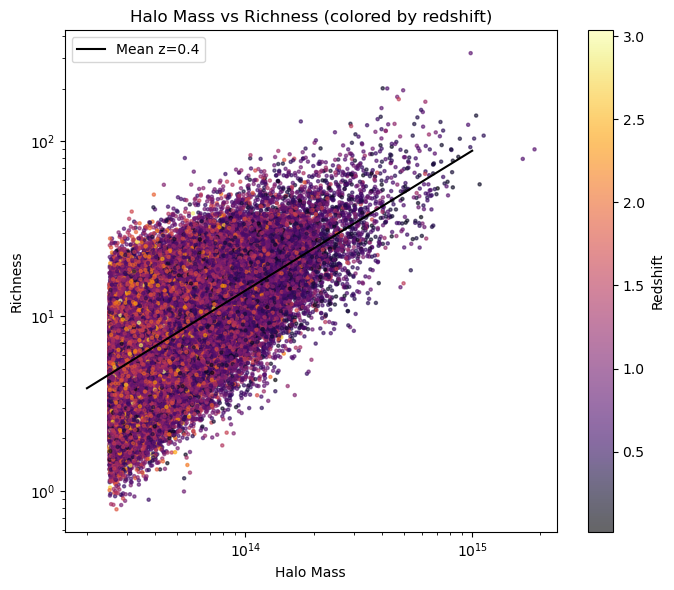

In [27]:
import matplotlib.pyplot as plt
import numpy as np

x = t_halo["halo_mass"]
y = t_halo["richness"]
z = t_halo["redshift"]

plt.figure(figsize=(7,6))

sc = plt.scatter(
    x,
    y,
    c=z,
    cmap='inferno',
    s=5,
    alpha=0.6
)

plt.xscale('log')
plt.yscale('log')

cbar = plt.colorbar(sc)
cbar.set_label("Redshift")
mass_array = np.linspace(np.log10(2e13), 15, 200)
mean = mass_richness.get_ln_mass_proxy_mean(mass_array,np.array([0.4]))
plt.plot(10**mass_array, np.exp(mean), label='Mean z=0.4', color='black')
plt.xlabel("Halo Mass")
plt.ylabel("Richness")
plt.title("Halo Mass vs Richness (colored by redshift)")
plt.tight_layout()
plt.legend()
plt.show()

In [3]:
t_halo = pandas.read_parquet("./cosmodc2_with_richness.parquet")
t_halo=t_halo[t_halo['log10_halo_mass'] >= 13.4]
t_cluster = pandas.read_parquet("./cosmodc2_with_richness.parquet")
Mp, zp = 10**14.3, 0.5
display(Table.read("/sps/lsst/users/maguena/cats/dc2/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0.fits"))


cosmo = ccl.Cosmology(
    Omega_c=0.1109 / 0.71**2,
    Omega_b=0.02258 / 0.71**2,
    h=0.71,
    n_s=0.963,
    sigma8=0.8,
    w0=-1.0,
    wa=0.0,
    transfer_function="boltzmann_camb"
)
display(t_halo["richness"])


halo_id,ra_true,dec_true,ra,dec,redshift_true,mass_fof,m200c,r200c,skysim_halo_id,NMEM,richness,NMEM_g_star2,NMEM_r_star2,NMEM_i_star2,NMEM_z_star2,NMEM_y_star2,richness_g_star2,richness_r_star2,richness_i_star2,richness_z_star2,richness_y_star2,ra_bary,dec_bary
int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64
1600020475,50.77596621112012,-27.11267297840223,50.775875822529436,-27.112584328955446,0.04530489444732666,2.247e+13,18901145086557.746,0.5539122181878964,4308786475,14,8.259415690053675,4,2,2,2,2,3.3159297517335684,2.0,2.0,2.0,2.0,50.86080257640612,-27.111068884566034
2700020475,49.46685631106464,-25.960657456295777,49.466814189348334,-25.960541211222015,0.04615640640258789,1.633e+13,15062094204754.93,0.5136732064502341,5608786475,14,7.310438276043445,7,5,5,5,5,3.9505018568471444,3.162710828265532,3.162710828265532,3.162710828265532,3.162710828265532,49.430749682006216,-26.004253136511434
17200020453,50.16400668612118,-25.25905307744378,50.16585579512233,-25.259404686564693,0.08653247356414795,2.283e+13,20441971397588.734,0.5883426733419929,9508786453,12,5.623277102797734,5,5,5,4,4,3.3387389360236903,3.3387389360236903,3.3387389360236903,3.130245439035445,3.130245439035445,50.10887874151731,-25.222612608640762
19000020453,49.51595503782168,-26.130631687629403,49.51865674267036,-26.131426039026245,0.09413313865661621,1.199e+13,10668658238016.902,0.47378993370163613,29908786453,15,6.997234500189672,7,7,7,7,7,3.975938934627579,3.975938934627579,3.975938934627579,3.975938934627579,3.975938934627579,49.526283728873516,-26.143323644925193
19800020453,50.68971804154461,-26.886508987581664,50.691634217578326,-26.88681304144144,0.08739697933197021,8.412e+13,71624983358738.03,0.8935768839339135,10408786453,25,10.377440167337566,12,11,9,8,8,5.102184303491505,4.807846043434688,4.353673518160678,4.0503547588246684,4.0503547588246684,50.71067924047927,-26.883765517046655
32800020453,51.49229315287324,-26.308837160731073,51.49405530538187,-26.309071814426567,0.08795535564422607,1.328e+13,10371945197971.832,0.4693405728944591,14908786453,7,4.078294904689155,2,2,2,2,2,1.284161206475952,1.284161206475952,1.284161206475952,1.284161206475952,1.284161206475952,51.53207787114288,-26.281769096943737
2000020442,51.02799219278836,-25.768148487504888,51.03054382968504,-25.767733992572435,0.10751283168792725,3.555e+13,31256384653340.848,0.6889763852240335,9408786442,22,9.068648511775608,3,3,3,3,2,1.7669316487994353,1.7669316487994353,1.7669316487994353,1.7669316487994353,1.5330209172234177,51.04052597864433,-25.76994686512187
32300020442,51.47772552281113,-25.82579874206229,51.48013416475692,-25.825311694587846,0.10751473903656006,1.339e+13,11587427913554.93,0.49502278717470843,43208786442,10,5.4538674639470575,5,4,4,3,3,3.6826146155436636,2.6826146155436636,2.6826146155436636,2.0956992167416817,2.0956992167416817,51.46172414586285,-25.805957090122217
33300020442,50.31241043560731,-26.69591460405023,50.315518939516316,-26.69559169836869,0.108817458152771,3.434e+13,29876928281239.438,0.6786574780101507,44708786442,16,6.788349932828027,8,8,8,8,8,4.952319670491652,4.952319670491652,4.952319670491652,4.952319670491652,4.952319670491652,50.28802465790821,-26.712593565283026


4          8.821487
6          2.975686
8          6.706266
10         8.494938
12        11.457687
            ...    
454348     9.567346
454366     6.079724
454405     5.099836
454439     6.812306
454450     9.178443
Name: richness, Length: 102478, dtype: float64

## Mass-Richness
Here we fit the parameters to make sure we obtain the same results as the one we used. We make a cut of 13.4 in log10 mass

In [29]:
def prior(params):
    if len(params) == 6:
        A, B, C, D, E, F = params
        if -2<C<2 and -2<E<2 and -2<F<2 and A > 0 and B > 0 and D > 0:
            return True
        else:
            return False
    else:
        A, B, C, D = params
        if -2<C<2 and A > 0 and B > 0 and D > 0:
            return True
        else:
            return False
def _ln_L(params, X, a, b, use_correction):
    # 1. Prior Check
    if not prior(params):
        return -np.inf
    
    # 2. Extract Data & Params
    pop, M, z = np.log(X["richness"]), X["halo_mass"], X["redshift"]
    
    if len(params) == 6:
        A, B, C, D, E, F = params
        mean_alpha = A + B*np.log(M/Mp) + C*np.log((1+z)/(1+zp))
        sigma = D + E*np.log(M/Mp) + F*np.log((1+z)/(1+zp))
    else:
        A, B, D, C = params
        mean_alpha = A + B*np.log(M/Mp) + C*np.log((1+z)/(1+zp))
        sigma = D
    
    # 3. Physicality Check (Sigma must be positive for all points)
    if np.any(sigma <= 0):
        return -np.inf
    
    # 4. Standard Log-likelihood calculation
    # Using np.sum for speed and stability
    term1 = -0.5 * np.log(2 * np.pi * sigma**2)
    term2 = -0.5 * ((pop - mean_alpha) / sigma)**2
    ln_L = np.sum(term1 + term2)
    
    # 5. Optional Truncation Correction (Corrected logic)
    if use_correction:
        # P(a < NMEM < b) = 0.5 * [erf((log(b)-mu)/(sig*sqrt2)) - erf((log(a)-mu)/(sig*sqrt2))]
        inv_sig_root2 = 1.0 / (sigma * np.sqrt(2))
        def erf_func(val):
            return scipy.special.erf((np.log(val) - mean_alpha) * inv_sig_root2)
        
        prob_in_bin = 0.5 * (erf_func(b) - erf_func(a))
        # Add the log of the normalization to the total likelihood
        ln_L -= np.sum(np.log(np.clip(prob_in_bin, 1e-10, None)))
        
    return ln_L

def MCMC(richesse_bin, redshift_bin, itt, redshift_params=True, correction=True):
    a, b = richesse_bin
    c, d = redshift_bin
    
    # Selection
    mask = (t_halo["richness"] > a) & (t_halo["richness"] < b) & \
           (t_halo["redshift"] > c) & (t_halo["redshift"] < d) 
            
    X = t_halo[mask]
    display(X)
    if len(X) < 10: # Safety check for empty bins
        print(f"Warning: Bin {richesse_bin}, {redshift_bin} has only {len(X)} clusters.")
        return {'mean': np.zeros(6 if redshift_params else 4), 'std': np.zeros(6 if redshift_params else 4)}

    ndim = 6 if redshift_params else 4
    nwalkers = 48 # Use a multiple of 2 or 4 for better threading
    
    # Better initialization
    if redshift_params:
        guess = np.array([3.2, 0.8, 0.1, 0.5, 0.01, 0.01])
    else:
        guess = np.array([3.2, 0.8, 0.5, 0.01])
        
    p0 = [guess + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, _ln_L, args=[X, a, b, correction])
    sampler.run_mcmc(p0, itt, progress=True)
    
    # Correct result extraction (Flattening)
    burn_in = int(itt * 0.3)
    unflat_samples = sampler.get_chain(discard=burn_in, flat=False)
    flat_samples = sampler.get_chain(discard=burn_in, flat=True)    
    return {
        'chains': unflat_samples,
        'mean': np.mean(flat_samples, axis=0),
        'median': np.median(flat_samples, axis=0),
        'std': np.std(flat_samples, axis=0)
    }

In [30]:
from tqdm import tqdm


# Run your MCMC once
res = MCMC(richesse_bin=(20,200), 
          redshift_bin=(0.2,0.8), 
          itt=3000, redshift_params=False, correction=True)
print(res)
# Extract chains and statistics
chains = res['chains']  # shape: (nsteps, nwalkers, 6) or similar
means = res['mean']     # length 6
stds  = res['std']      # length 6
medians = res['median']
# Print best-fit values
param_names = ['A','B','C','D','E','F']
for i, name in enumerate(param_names):
    print(f"{name}: mean={means[i]:.4f}, std={stds[i]:.4f}")
    print(f"{name}: median={medians[i]:.4f}, std={stds[i]:.4f}")

# ------------------------------------------------------------------------------
# Plot chains to check convergence
# ------------------------------------------------------------------------------
n_params = 6
nsteps, nwalkers = chains.shape[0], chains.shape[1]

fig, axes = plt.subplots(n_params, 1, figsize=(12, 2*n_params), sharex=True)
for i in range(n_params):
    ax = axes[i]
    for w in range(nwalkers):
        ax.plot(chains[:, w, i], alpha=0.5)
    # Show mean and median lines
    mean_i = np.mean(chains[:, :, i])
    median_i = np.median(chains[:, :, i])
    ax.axhline(mean_i, color='red', linestyle='--', label='Mean')
    ax.axhline(median_i, color='green', linestyle='-.', label='Median')
    ax.set_ylabel(param_names[i])
    ax.legend()
axes[-1].set_xlabel('MCMC step')
plt.tight_layout()
plt.show()


,redshift,halo_mass,log10_halo_mass,richness
68,0.268834,1.713726e+14,14.233941,27.220420
133,0.355549,5.034753e+13,13.701978,21.785696
152,0.393349,9.249381e+13,13.966113,38.040076
159,0.368943,1.396504e+14,14.145042,23.752469
205,0.467930,2.551733e+14,14.406835,24.052956
...,...,...,...,...
451768,0.722122,4.384327e+13,13.641903,26.409909
451825,0.715549,1.615889e+14,14.208412,24.860757
451953,0.768100,1.798914e+14,14.255010,37.429628
452015,0.781028,1.781164e+14,14.250704,29.917900


100%|██████████| 3000/3000 [01:35<00:00, 31.41it/s]

{'chains': array([[[3.22968983e+00, 7.55437314e-01, 5.03658530e-01, 1.85087747e-01],
        [3.19636942e+00, 7.74941293e-01, 5.21363229e-01, 8.12887977e-02],
        [3.29758781e+00, 6.78281330e-01, 4.66601317e-01, 2.20754029e-02],
        ...,
        [3.19793084e+00, 7.76105026e-01, 5.08378131e-01, 2.11995660e-01],
        [3.23479618e+00, 7.50294893e-01, 5.00116462e-01, 8.57524288e-02],
        [3.19286782e+00, 8.03431546e-01, 5.12370837e-01, 9.70421545e-02]],

       [[3.22968983e+00, 7.55437314e-01, 5.03658530e-01, 1.85087747e-01],
        [3.19636942e+00, 7.74941293e-01, 5.21363229e-01, 8.12887977e-02],
        [3.29758781e+00, 6.78281330e-01, 4.66601317e-01, 2.20754029e-02],
        ...,
        [3.20088058e+00, 7.79845847e-01, 5.07438399e-01, 1.92414554e-01],
        [3.23406338e+00, 7.50890437e-01, 5.00092284e-01, 1.01406108e-01],
        [3.19286782e+00, 8.03431546e-01, 5.12370837e-01, 9.70421545e-02]],

       [[3.22968983e+00, 7.55437314e-01, 5.03658530e-01, 1.85087747e-01

IndexError: index 4 is out of bounds for axis 0 with size 4

## Save to sacc

In [9]:
import math
import itertools

import numpy as np

from astropy.table import Table

from astropy.io import fits
from scipy import stats
from typing import Any
import sacc

data_table = t_cluster
data_table = data_table[data_table['redshift'] >= 0.2]
data_table = data_table[data_table['redshift'] <= 1.0]
data_table = data_table[data_table['richness'] >= 20]
data_table = data_table[data_table['richness'] <= 200]


area = 439.78986

cluster_z = data_table["redshift"]
cluster_richness = np.log10(data_table["richness"])

bins_rich = np.log10([20,35,70,200])
bins_z = np.array([0.2, 0.4, 0.6, 0.8, 1.0])

cluster_counts, z_edges, richness_edges, _ = stats.binned_statistic_2d(
    cluster_z, cluster_richness, None, "count", bins=[bins_z, bins_rich]
)
print(cluster_counts)
print(np.sum(cluster_counts))
covariance = np.diag(cluster_counts.flatten())
print(np.mean(cluster_z), np.min(cluster_z))
s_count = sacc.Sacc()
bin_z_labels = []
bin_richness_labels = []

survey_name = "cosmodc2_halos"
s_count.add_tracer("survey", survey_name, area)

for i, z_bin in enumerate(zip(z_edges[:-1], z_edges[1:])):
    lower, upper = z_bin
    bin_z_label = f"bin_z_{i}"
    s_count.add_tracer("bin_z", bin_z_label, lower, upper)
    bin_z_labels.append(bin_z_label)

for i, richness_bin in enumerate(zip(richness_edges[:-1], richness_edges[1:])):
    lower, upper = richness_bin
    bin_richness_label = f"rich_{i}"
    s_count.add_tracer("bin_richness", bin_richness_label, lower, upper)
    bin_richness_labels.append(bin_richness_label)

#  pylint: disable-next=no-member
cluster_count = sacc.standard_types.cluster_counts

counts_and_edges = zip(
    cluster_counts.flatten(), itertools.product(bin_z_labels, bin_richness_labels)
)


for counts, (bin_z_label, bin_richness_label) in counts_and_edges:
    s_count.add_data_point(
        cluster_count, (survey_name, bin_richness_label, bin_z_label), int(counts)
    )
s_count.add_covariance(covariance)
s_count.to_canonical_order()
s_count.save_fits("./outputs_mor/clusters_sacc_file.sacc", overwrite=True)
s_count.save_fits("./outputs_cosmo/clusters_sacc_file.sacc", overwrite=True)
s_count.save_fits("./outputs_both/clusters_sacc_file.sacc", overwrite=True)
s_count.save_fits("./clusters_sacc_file.sacc", overwrite=True)


[[429. 154.  29.]
 [757. 230.  36.]
 [896. 288.  30.]
 [925. 237.  29.]]
4040.0
0.6493313498426192 0.20034563541412354
